# Application of Weak Supervision to Medical NLP using SNORKEL

In [1]:
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install tensorflow
!pip install keras
!pip install seaborn
!pip install snorkel

     |████████████████████████████████| 143kB 4.6MB/s 
     |████████████████████████████████| 61kB 25.1MB/s 
     |████████████████████████████████| 225kB 37.3MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure

from snorkel.labeling import PandasLFApplier
from snorkel.labeling import labeling_function
from snorkel.labeling import LFAnalysis
from snorkel.labeling import MajorityLabelVoter
from snorkel.labeling import LabelModel
from snorkel.labeling import LabelingFunction
from snorkel.labeling import filter_unlabeled_dataframe

RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

## Load Dataset

We're using the CrowdTruth dataset, containing sentences from PubMed articles describing *cause* or *treat* relations. The dataset includes expert and crowdsourcing labels.

**CrowdTruth Data:** https://github.com/CrowdTruth/Medical-Relation-Extraction

In [45]:
 ! git clone https://github.com/CrowdTruth/Medical-Relation-Extraction.git
 import os
 os.chdir('Medical-Relation-Extraction')

fatal: destination path 'Medical-Relation-Extraction' already exists and is not an empty directory.


In [77]:
cause_raw = pd.read_csv('./ground_truth_cause.csv')
treat_raw = pd.read_csv('./ground_truth_treat.csv')

In [78]:
# Preprocess and merge raw CauseTreat data
drop_cols = ['relation', 'test_partition', 'sentence_relation_score', 
            'term1_UMLS', 'term2_UMLS', 'UMLS_seed_relation', 'b1', 'b2', 'e1', 'e2']

cause = cause_raw.drop(columns=drop_cols)
treat = treat_raw.drop(columns=drop_cols)

treat = treat.drop(columns=['term1', 'term2'])

data = cause.merge(treat, on='SID', suffixes=('_cause', '_treat'))
data = data.drop(['sentence_treat'], axis=1)
data = data.rename(columns = {'sentence_cause': 'sentence'})

In [4]:
data.head()

,SID,crowd_cause,baseline_cause,expert_cause,term1,term2,sentence,crowd_treat,baseline_treat,expert_treat
0,100003,-0.847943,1,NaN,AUTISM,TANTRUM,"The limited data suggest that, in children wit...",-1.000000,-1,NaN
1,100039,-0.658257,1,NaN,SLEEP PROBLEM,FAMILY STRESS,SLEEP PROBLEMs are associated with difficult b...,-1.000000,-1,NaN
2,100079,0.929981,1,NaN,CEREBELLAR ATAXIA,DYSFUNCTION OF THE CEREBELLUM,The term CEREBELLAR ATAXIA is employed to indi...,-0.897938,-1,NaN
3,100086,0.520756,1,NaN,CEREBELLAR DEGENERATION,CHRONIC ETHANOL ABUSE,Non hereditary causes of cerebellar degenerati...,-1.000000,-1,NaN
4,100145,-0.521909,1,NaN,HEART PROBLEM,ARTHRITIS,The disorder can present with a migratory ture...,-1.000000,-1,NaN


**Some statistics on the CrowdTruth datasets:**

In [79]:
n_cause = cause.shape[0]
n_treat = treat.shape[0]
print('Row in cause groundtruth: {}'.format(n_cause))
print('Row in treat groundtruth: {}'.format(n_treat))

n_different_SID = cause[~cause['SID'].isin(treat['SID'])].shape[0]
print('Rows with sentence id SID in cause that don\'t appear in treat: {}'.format(n_different_SID))

n_expert_cause = cause[cause['expert'].notnull()].shape[0]
print('Cause expert rows: {}'.format(n_expert_cause))

n_expert_treat = treat[treat['expert'].notnull()].shape[0]
print('Treat expert rows: {}'.format(n_expert_treat))

cause_accuracy = cause[cause['expert'] == 1].shape[0] / n_expert_cause
print('Accuracy of baseline labels in cause: {:.4}%'.format(cause_accuracy * 100))

treat_accuracy = treat[treat['expert'] == 1].shape[0] / n_expert_treat
print('Accuracy of baseline labels in treat: {:.4}%'.format(treat_accuracy * 100))

Row in cause groundtruth: 3984
Row in treat groundtruth: 3984
Rows with sentence id SID in cause that don't appear in treat: 0
Cause expert rows: 975
Treat expert rows: 621
Accuracy of baseline labels in cause: 25.33%
Accuracy of baseline labels in treat: 47.34%


### Additional Data

To increase the data volume and test the application of the same labeling functions (LFs) to new data we also load additional data sources for *cause* and *treat*.

They can be switch on/off for processing using the below constants.

**BIOTEXT Data:** https://biotext.berkeley.edu/dis_treat_data.html

In [80]:
USE_BIOTEXT = False

In [60]:

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))



ModuleNotFoundError: No module named 'google.colab'

In [81]:
# Some preprocessing

f = open('./biotext.txt', encoding = "ISO-8859-1")
f_data = []
for line in f.readlines():
    line = line[:-1] # Remove linebreak
    f_data.append(line.split('||'))
f.close()

rows = []
for l in f_data:
    if l[1] not in ['NONE', 'TREATONLY', 'DISONLY', 'TO_SEE']:
        dis_re = re.compile('<DIS.*>(.*)</DIS.*>')
        disease = dis_re.search(l[0]).group(1)
        treat_re = re.compile('<TREAT.*>(.*)</TREAT.*>')
        treat = treat_re.search(l[0]).group(1)
        
        sent = re.sub(r'<.*?>', '', l[0])
        
        rows.append([sent, l[1], treat.upper(), disease.upper()])

biotext = pd.DataFrame(data=rows, columns=['sentence', 'type', 'term1', 'term2'])
print('Shape of biotext data: {}'.format(biotext.shape))
biotext.head()

Shape of biotext data: (964, 4)


,sentence,type,term1,term2
0,We conclude that to reduce the rate of macros...,PREVENT,GOOD GLYCEMIC CONTROL,MACROSOMIC INFANTS IN GESTATIONAL DIABETES CA...
1,Although long-term survival can be achieved by...,VAGUE,CORRECTIVE SURGERY,HYPOPLASIA
2,OBJECTIVE : To study the safety and efficacy ...,TREAT_FOR_DIS,METHYLPHENIDATE,ATTENTION DEFICIT HYPERACTIVITY DISORDER ( AD...
3,CONCLUSION : Methylphenidate is effective in...,TREAT_FOR_DIS,METHYLPHENIDATE,ADHD
4,BACKGROUND : Antiplatelet therapy with aspir...,TREAT_FOR_DIS,ANTIPLATELET THERAPY WITH ASPIRIN AND SYSTEMA...,CARDIOVASCULAR MORBIDITY AND MORTALITY AFTER ...


In [43]:
biotext.sentence[0]

'We conclude that to reduce the rate of  macrosomic infants in gestational diabetes cases  ,  good glycemic control  should be initiated before 34 completed gestational weeks .'

**Adverse Drug Effects Corpus:** https://github.com/davidsbatista/Annotated-Semantic-Relationships-Datasets/blob/master/datasets/ADE-Corpus-V2.zip

Contains annotated MEDLINE articles with causal relations between drugs and adverse effects.

In [82]:
USE_ADE = False

In [11]:

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


ModuleNotFoundError: No module named 'google.colab'

In [83]:
cause_ade_raw = pd.read_csv('./DRUG-AE.csv', sep = '|', header = None)
cause_ade_raw.columns = ['PID','sentence','term1','sp1','sp2','term2', 'sp3', 'sp4']
drop_cols = ['PID','sp1', 'sp2', 'sp3', 'sp4']
cause_ade = cause_ade_raw.drop(columns=drop_cols)
cause_ade = cause_ade.dropna()
cause_ade.insert(2, 'type', 'CAUSE')
cause_ade.drop_duplicates(subset='sentence', keep='first', inplace=True)
cause_ade['term1'] = cause_ade['term1'].apply(lambda x: x.upper())
cause_ade['term2'] = cause_ade['term2'].apply(lambda x: x.upper())
cause_ade = cause_ade.sample(n=964, random_state=RANDOM_SEED)
print('Shape of ADE data: {}'.format(cause_ade.shape))
cause_ade.head()

Shape of ADE data: (964, 4)


,sentence,term1,type,term2
3043,Torsade de pointes associated with moxifloxaci...,TORSADE DE POINTES,CAUSE,MOXIFLOXACIN
4772,Three patients developed proteinuria following...,PROTEINURIA,CAUSE,GOLD
2993,An apparent link is described between the use ...,RED BLOOD CELL ANEMIA,CAUSE,MMF
1801,5-fluorouracil (5-FU)-associated peripheral ne...,PERIPHERAL NEUROPATHY,CAUSE,5-FLUOROURACIL
3693,CONCLUSIONS: Spontaneous hemothorax is a rare ...,SPONTANEOUS HEMOTHORAX,CAUSE,LMWH


### Creating Training data

We split the data into Train, Dev and Test sets and add a label column to represent the true class label.

Class labels: 

In [84]:
ABSTAIN = -1 # returned by abstaining LFs
NO_RELATION = 0
CAUSE = 1
TREAT = 2

In [85]:
# Set expert rows to truth value (rather than saying wether baseline is correct)
data['expert_cause'] == data['baseline_cause'].where(data['expert_cause'] == 1)
data['expert_cause'] == -data['baseline_cause'].where(data['expert_cause'] == -1)
data['expert_treat'] == data['baseline_treat'].where(data['expert_treat'] == 1)
data['expert_treat'] == -data['baseline_treat'].where(data['expert_treat'] == -1)

data[data['expert_cause'].notnull()].head()

,SID,crowd_cause,baseline_cause,expert_cause,term1,term2,sentence,crowd_treat,baseline_treat,expert_treat
2344,820001,-0.823223,-1,-1.0,ANGI PECTORIS,METOPROLOL,"Keech AC, Harper RW, Harrison PM et al. Pharma...",0.707107,1,-1.0
2345,820003,0.755929,-1,-1.0,HYPOGLYCEMIA,GLUCOSE,Cortisol and growth hormone are also secreted ...,0.733017,1,-1.0
2346,820004,-0.767505,-1,-1.0,NOCTURL HYPOGLYCEMIA,FASTING BLOOD GLUCOSE,The risk of NOCTURL HYPOGLYCEMIA is lower with...,0.929981,1,-1.0
2347,820005,0.943456,-1,-1.0,HYPERGLYCEMIA,INSULIN,"a • Increases glycogenolysis in the liver, re...",-0.685515,1,-1.0
2348,820009,0.603023,-1,-1.0,RHEUMATOID ARTHRITIS,AKINRA,1 Specific Drugs Drug Interaction Com...,-0.698489,1,-1.0


In [86]:
# Load biotext data
if USE_BIOTEXT:
    char_arr = np.chararray((biotext.shape[0], 10), unicode=True)
    biotext_df = pd.DataFrame(char_arr, columns=data.columns)
    biotext_df['sentence'] = biotext['sentence'].values
    biotext_df['term1'] = biotext['term1'].values
    biotext_df['term2'] = biotext['term2'].values
    biotext_df['expert_cause'] = None
    biotext_df['expert_treat'] = None
    last_sid = int(data['SID'].max(axis=0))
    biotext_df['SID'] = np.arange(last_sid + 1, last_sid + 1 + biotext.shape[0])
    data = pd.concat([data, biotext_df])

In [87]:
# Load ADE data
if USE_ADE:
    char_arr_ade = np.chararray((cause_ade.shape[0], 10), unicode=True)
    ade_df = pd.DataFrame(char_arr_ade, columns=data.columns)
    ade_df['sentence'] = cause_ade['sentence'].values
    ade_df['term1'] = cause_ade['term1'].values
    ade_df['term2'] = cause_ade['term2'].values
    ade_df['expert_cause'] = None
    ade_df['expert_treat'] = None
    last_sid = int(data['SID'].max(axis=0))
    ade_df['SID'] = np.arange(last_sid + 1, last_sid + 1 + cause_ade.shape[0])
    data = pd.concat([data, ade_df])

In [88]:
data.tail()

,SID,crowd_cause,baseline_cause,expert_cause,term1,term2,sentence,crowd_treat,baseline_treat,expert_treat
3979,908349,-0.765918,-1,-1.0,PARKINSON'S DISEASE,AMANTADINE,A 61 year old man with PARKINSON'S DISEASE (PD...,0.929981,1,1.0
3980,908350,-0.558274,-1,-1.0,DEPRESSION,IMIPRAMINE,With successful treatment of the patient's dep...,0.866025,1,1.0
3981,908351,-0.558274,-1,-1.0,BEPRIDIL,ANGI,Five of 15 patients receiving bepridil did not...,0.878114,1,1.0
3982,908360,-0.839872,-1,-1.0,HEMOPHILIA A,FACTOR VIII,The development of antibodies to factor VIII i...,0.956183,1,1.0
3983,908361,0.560112,-1,-1.0,FOOD STIMULATED GASTRO OESOPHAGEAL REFLUX MECH...,CISAPRIDE,The influence of CISAPRIDE on FOOD STIMULATED ...,-0.599108,1,1.0


In [89]:
# Filter out all rows where there is either no expert label or only one expert label == False 
# (-> we don't know the ground truth), expert labels are never 1 both at the same time
train = data[(data['expert_cause'].isnull() & data['expert_treat'].isnull()) |
                 (data['expert_cause'].isnull() & (data['expert_treat'] == -1)) |
                 (data['expert_treat'].isnull() & (data['expert_cause'] == -1))
            ].copy()

print('Training samples: {}'.format(train.shape[0]))

expert = data[~data['SID'].isin(train['SID'])].copy()
expert.loc[(expert['expert_cause'] == -1) & (expert['expert_treat'] == -1), 'label'] = NO_RELATION
expert.loc[expert['expert_cause'] == 1, 'label'] = CAUSE
expert.loc[expert['expert_treat'] == 1, 'label'] = TREAT

val, test = train_test_split(expert, test_size=0.2, random_state=RANDOM_SEED)
dev, val = train_test_split(val, test_size=0.65, random_state=RANDOM_SEED)
print('Dev samples: {}'.format(dev.shape[0]))
print('Validation samples: {}'.format(val.shape[0]))
print('Test samples: {}'.format(test.shape[0]))

dev[['crowd_cause', 'baseline_cause', 'expert_cause', 'crowd_treat', 'baseline_treat', 'expert_treat', 'label']].head()

Training samples: 3363
Dev samples: 173
Validation samples: 323
Test samples: 125


,crowd_cause,baseline_cause,expert_cause,crowd_treat,baseline_treat,expert_treat,label
3734,-1.000000,-1,-1.0,0.985329,1,1.0,2.0
3958,-1.000000,-1,-1.0,0.993127,1,1.0,2.0
3900,-0.892789,-1,-1.0,0.948683,1,1.0,2.0
3216,-0.769060,1,1.0,-0.884530,-1,-1.0,1.0
2407,-0.638842,-1,-1.0,-0.638842,1,-1.0,0.0


## Setting up SNORKEL

Load our gold labels:

In [90]:
gold_dev = dev['label']
gold_val = val['label']
gold_test = test['label']

## Labeling Functions:

In [53]:
import random

@labeling_function()
def LF_baseline(c):
    if c.baseline_cause == 1 and c.baseline_treat == -1:
        return CAUSE
    elif c.baseline_cause == -1 and c.baseline_treat == 1:
        return TREAT
    elif c.baseline_cause == -1 and c.baseline_treat == -1:
        return NO_RELATION
    
    return 0


@labeling_function()
def LF_crowd(c):
    if isinstance(c.crowd_cause, str):
        return ABSTAIN
    
    if c.crowd_cause >= 0 and c.crowd_treat < 0:
        return CAUSE
    elif c.crowd_cause < 0 and c.crowd_treat >= 0:
        return TREAT
    elif c.crowd_cause < 0 and c.crowd_treat < 0:
        return NO_RELATION
    
    return 0



@labeling_function()
def LF_crowd_rand(c):
    rand = np.random.choice([True, False], 1, p=[0.2, 0.8])
    
    if rand:
        return LF_crowd(c)
    else:
        return ABSTAIN

We check the sentences for the appearance of certain keywords.

In [54]:
def keyword_lookup(c, keywords, label):
    for kw in keywords:
        if re.search(kw, c.sentence, re.IGNORECASE):
            return label
    return ABSTAIN

def make_keyword_lf(keywords, label):
    return LabelingFunction(
        name="keywords_{}".format(label),
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

In [55]:
pos_cause = ['actuate','affect','after,''agent(s) of','associated with','avoid','because of','begin as',
             'breed','causing','cause(d) (by|of)','cause of','causative (agent of)',
             'characterized by','compel','complicate','complication(s) of','(condition) characterized by',
             'confirmed','consequence(s) of','consistent with','contribute','create',
             'decide','decrease','development of','develop(s) in patient(s) with',
             'disorder' + 'caused by','due to','determine','effect','effectuate','encourage','evoked by',
             'facilitate','finding in patients presenting with','following','from','high risk of','impel',
             'impose','increase','indication of','is common (with|in)','produce','induce','influence',
             'infection from','initiate','inspire','instigate','lead','lead(ing|s) to','make',
             'manifest(s) as','motivate','generate','occurs (by|in)','patient(s) (with|has)',
             'precipitate','(patient) present(s|ed) (with)','present in patients with',
             'progress to','promote','prompt','propel','provide','provoke','reduce',
             'recognizable by','regulate','result(ing) in','restricted by','risk factor(s) for',
             'result(s) from','set','side effect(s) of','symptom(s) (of|in)',
             'shape','stimulate','trigger']

neg = ['not (be|in)', '(is|was|does|did) not', 'absence (of)', 'exclude', 'controversial']

pos_treat = ['treatment of', 'for the prevention of', 'prevent(ing)', 'treated with',
             'prophylaxis', 'protection against', 'protective effect', 'use of',
             'associated with (reduction)', 'treatment of', 'significantly reduced', 'reduce(d)',
             'to treat', 'treat', 'increasing doses', 'related to', 'decrease', 'treatment with',
             'role of', 'reduce risk of', 'reduced', 'administration', 'prescribed', 'therapy with',
             'immunize', 'efficacy (of)', 'prescribed', 'relief of', 'intake of', 'use of',
             'patients receiving', 'treats']

LF_cause_keywords = make_keyword_lf(pos_cause, CAUSE)
LF_treat_keywords = make_keyword_lf(pos_treat, TREAT)
LF_negative_keywords = make_keyword_lf(neg, NO_RELATION)

Furthermore we search for more complex regular expressions.

In [56]:
# REGEX helpers
def rule_regex_search_btw_AB(c, pattern, label):
    term1 = re.escape(c.term1)
    term2 = re.escape(c.term2)
    return label if re.search(re.escape(term1) + pattern + re.escape(term2), c.sentence, flags=re.I) else ABSTAIN


def rule_regex_search_btw_BA(c, pattern, label):
    term1 = re.escape(c.term1)
    term2 = re.escape(c.term2)
    return label if re.search(re.escape(term2) + pattern + re.escape(term1), c.sentence, flags=re.I) else ABSTAIN


def rule_regex_search_before_A(c, pattern, label):
    term1 = re.escape(c.term1)
    term2 = re.escape(c.term2)
    return label if re.search(pattern + re.escape(term1) + '.*' + re.escape(term2), c.sentence, flags=re.I) else ABSTAIN


def rule_regex_search_before_B(c, pattern, label):
    term1 = re.escape(c.term1)
    term2 = re.escape(c.term2)
    return label if re.search(pattern + re.escape(term2) + '.*' + re.escape(term1), c.sentence, flags=re.I) else ABSTAIN


In [25]:
def ltp(x):
    return '(' + '|'.join(x) + ')'
    
causal_past = ['induced', 'caused', 'due', 'evoked', 'characterized by']
@labeling_function()
def LF_b_induced_by_a(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + '.{0,9}(by|to).{0,50}', CAUSE)

@labeling_function()
def LF_b_induced_by_a_tight(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + ' (by|to) ', CAUSE)   

causal = ['cause[s|d]?', 'induce[s|d]?', 'associated with']
@labeling_function()
def LF_a_cause_b(c):
    return CAUSE if (
        re.search(re.escape(c.term1) + '.{0,50} ' + ltp(causal) + '.{0,50}' + re.escape(c.term2), c.sentence, re.I)
        and not re.search(re.escape(c.term1) + '.{0,50}(not|no).{0,20}' + ltp(causal) + '.{0,50}' + re.escape(c.term2), c.sentence, re.I)
    ) else ABSTAIN

treat = ['treat', 'effective', 'prevent', 'resistant', 'slow', 'promise', 'therap', 'decrease', 'relief']

@labeling_function()
def LF_b_treat_a(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(treat) + '.{0,50}', TREAT)

@labeling_function()
def LF_a_treat_b(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(treat) + '.{0,50}', TREAT)

@labeling_function()
def LF_treat_b(c):
    return rule_regex_search_before_B(c, ltp(treat) + '.{0,50}', TREAT)

@labeling_function()
def LF_a_treat_b_wide(c):
    return rule_regex_search_btw_AB(c, '.{0,200}' + ltp(treat) + '.{0,200}', TREAT)

@labeling_function()
def LF_improve_before_disease(c):
    return rule_regex_search_before_B(c, 'improv.*', TREAT)

pat_terms = ['in a patient with ', 'in patients with']
@labeling_function()
def LF_in_patient_with(c):
    return CAUSE if re.search(ltp(pat_terms) + re.escape(c.term2), c.sentence, flags=re.I) else ABSTAIN

uncertain = ['combin', 'possible', 'unlikely']
@labeling_function()
def LF_uncertain(c):
    return rule_regex_search_before_A(c, ltp(uncertain) + '.*', NO_RELATION)

@labeling_function()
def LF_induced_other(c):
    return NO_RELATION if re.search(re.escape(c.term1) + '.{20,1000}-induced ' + re.escape(c.term2), c.sentence, flags=re.I) else ABSTAIN

@labeling_function()
def LF_far_a_b(c):
    return rule_regex_search_btw_AB(c, '.{100,5000}', NO_RELATION)

@labeling_function()
def LF_far_b_a(c):
    return rule_regex_search_btw_BA(c, '.{100,5000}', NO_RELATION)

@labeling_function()
def LF_risk_b(c):
    return rule_regex_search_before_B(c, 'risk of ', NO_RELATION)

@labeling_function()
def LF_develop_b_following_a(c):
    return CAUSE if re.search(r'develop.{0,25}' + re.escape(c.term2) + '.{0,25}following.{0,25}' + re.escape(c.term1), c.sentence, flags=re.I) else ABSTAIN

procedure, following = ['inject', 'administrat'], ['following']

@labeling_function()
def LF_b_following_a(c):
    return TREAT if re.search(re.escape(c.term2) + '.{0,50}' + ltp(following) + '.{0,20}' + re.escape(c.term1) + '.{0,50}' + ltp(procedure), c.sentence, flags=re.I) else ABSTAIN

@labeling_function()
def LF_measure(c):
    return NO_RELATION if re.search('measur.{0,75}' + re.escape(c.term1), c.sentence, flags=re.I) else ABSTAIN

@labeling_function()
def LF_level(c):
    return NO_RELATION if re.search(re.escape(c.term1) + '.{0,25} level', c.sentence, flags=re.I) else ABSTAIN

@labeling_function()
def LF_neg_b(c):
    return NO_RELATION if re.search('(none|not|no) .{0,25}' + re.escape(c.term2), c.sentence, flags=re.I) else ABSTAIN

WEAK_PHRASES = ['none', 'although', 'was carried out', 'was conducted',
                'seems', 'suggests', 'risk', 'implicated',
               'the aim', 'to (investigate|assess|study)']

WEAK_RGX = r'|'.join(WEAK_PHRASES)

@labeling_function()
def LF_weak_assertions(c):
    return NO_RELATION if re.search(WEAK_RGX, c.sentence, flags=re.I) else ABSTAIN


### Applying LFs to Dev and Train set

We first apply the LFs to our datasets (i.e. label the samples) and look at their statistics. For the development set we supply gold labels in order to see how well our functions perform compared to the expert labels. These results can then be used to iterate on the functions.

In [91]:
'''
LFs_regex = [LF_cause_keywords,
             LF_treat_keywords, 
             LF_negative_keywords, 
             #LF_b_induced_by_a, 
             #LF_b_induced_by_a_tight,
             LF_b_treat_a, 
             LF_a_treat_b, 
             LF_treat_b, 
             LF_a_treat_b_wide, 
             #LF_improve_before_disease, 
             #LF_in_patient_with, 
             LF_uncertain, 
             #LF_induced_other, 
             #LF_far_a_b, 
             LF_far_b_a, 
             #LF_risk_b, 
             #LF_develop_b_following_a, 
             #LF_b_following_a, 
             LF_measure, 
             #LF_level, 
             LF_neg_b, 
             #LF_weak_assertions
            ]
'''

LFs_regex = [LF_cause_keywords,
             LF_treat_keywords, 
             LF_negative_keywords, 
             #LF_b_induced_by_a, 
             #LF_b_induced_by_a_tight,
             LF_b_treat_a, 
             LF_a_treat_b, 
             LF_treat_b, 
             LF_a_treat_b_wide, 
             #LF_improve_before_disease, 
             #LF_in_patient_with, 
             LF_uncertain, 
             #LF_induced_other, 
             LF_far_a_b, 
             #LF_far_b_a, 
             #LF_risk_b, 
             #LF_develop_b_following_a, 
             #LF_b_following_a, 
             LF_measure, 
             #LF_level, 
             LF_neg_b, 
             #LF_weak_assertions,
             #LF_baseline,
             #LF_crowd,
             #LF_crowd_rand
            ]
LFs = LFs_regex

applier = PandasLFApplier(lfs=LFs)

L_train = applier.apply(df=train)
L_dev = applier.apply(df=dev)
L_valid = applier.apply(df=val)

100%|██████████| 323/323 [00:01<00:00, 227.06it/s]


In [32]:
LFAnalysis(L=L_dev, lfs=LFs).lf_summary(Y=gold_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keywords_1,0,[1],0.520231,0.520231,0.381503,30,60,0.333333
keywords_2,1,[2],0.427746,0.427746,0.242775,55,19,0.743243
keywords_0,2,[0],0.046243,0.046243,0.046243,3,5,0.375000
LF_b_treat_a,3,[2],0.028902,0.028902,0.017341,4,1,0.800000
LF_a_treat_b,4,[2],0.023121,0.023121,0.011561,4,0,1.000000
LF_treat_b,5,[2],0.028902,0.028902,0.017341,4,1,0.800000
LF_a_treat_b_wide,6,[2],0.023121,0.023121,0.011561,4,0,1.000000
LF_uncertain,7,[],0.000000,0.000000,0.000000,0,0,0.000000
LF_far_a_b,8,[0],0.005780,0.005780,0.005780,0,1,0.000000
LF_measure,9,[],0.000000,0.000000,0.000000,0,0,0.000000


In [33]:
LFAnalysis(L=L_train, lfs=LFs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keywords_1,0,[1],0.520071,0.520071,0.363961
keywords_2,1,[2],0.270294,0.270294,0.181980
keywords_0,2,[0],0.046090,0.046090,0.037764
LF_b_treat_a,3,[2],0.021112,0.021112,0.011002
LF_a_treat_b,4,[2],0.007434,0.007434,0.004758
LF_treat_b,5,[2],0.008921,0.008921,0.007434
LF_a_treat_b_wide,6,[2],0.009515,0.009515,0.006542
LF_uncertain,7,[0],0.001189,0.001189,0.000892
LF_far_a_b,8,[0],0.011002,0.011002,0.010110
LF_measure,9,[0],0.002379,0.002379,0.002081


## LF Analysis

Test our LFs against the dev set to see how well they perform before training the model.

In [34]:
acc_arr = []
abstain_arr = []
not_abstain_arr = []
acc_on_pred_arr = []
df_index = []
for i, lf in enumerate(LFs):
    tp = np.sum(L_dev[:, i] == gold_dev)
    acc = tp / len(gold_dev)
    acc_arr.append(acc)
    abstain = np.sum(np.ravel(L_dev[:, i]) == ABSTAIN)
    not_abstain = (len(gold_dev) - abstain)/len(gold_dev)
    abstain_arr.append(abstain/len(gold_dev))
    not_abstain_arr.append(not_abstain)
    acc_on_pred = tp / (len(gold_dev) - abstain)
    acc_on_pred_arr.append(acc_on_pred)
    df_index.append(lf.name)
    
df = pd.DataFrame([acc_arr, abstain_arr, not_abstain_arr, acc_on_pred_arr], columns=df_index, index=['Acc', 'Abstain', 'Not abstaining', 'Acc. on pred'])
stats_1 = df.transpose()
stats_1 = stats_1.sort_values('Not abstaining', ascending=False)
stats_1 = stats_1.iloc[:15, :]
stats_1

/Users/Emanuel/anaconda3/envs/snorkel-new/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


,Acc,Abstain,Not abstaining,Acc. on pred
LF_crowd,0.763006,0.000000,1.000000,0.763006
keywords_1,0.173410,0.479769,0.520231,0.333333
keywords_2,0.317919,0.572254,0.427746,0.743243
keywords_0,0.017341,0.953757,0.046243,0.375000
LF_b_treat_a,0.023121,0.971098,0.028902,0.800000
LF_treat_b,0.023121,0.971098,0.028902,0.800000
LF_a_treat_b,0.023121,0.976879,0.023121,1.000000
LF_a_treat_b_wide,0.023121,0.976879,0.023121,1.000000
LF_far_a_b,0.000000,0.994220,0.005780,0.000000
LF_neg_b,0.000000,0.994220,0.005780,0.000000


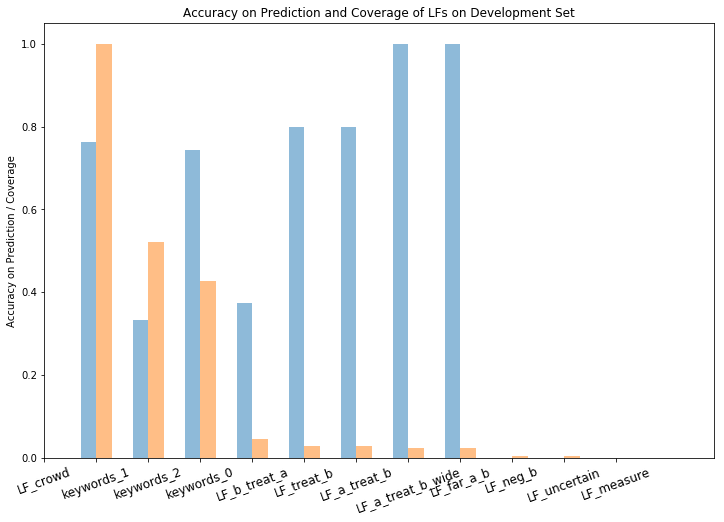

In [35]:
figure(figsize=(12, 8))

x_pos = np.arange(len(stats_1))
plt.bar(x_pos-0.15, stats_1['Acc. on pred'], width=0.3, align='center', alpha=0.5)
plt.bar(x_pos+0.15, stats_1['Not abstaining'], width=0.3, align='center', alpha=0.5)
plt.xticks(x_pos-1, stats_1.index, rotation=20, fontsize=12)
plt.ylabel('Accuracy on Prediction / Coverage')
plt.title('Accuracy on Prediction and Coverage of LFs on Development Set')

plt.show()

## Generative Model

In [92]:
majority_model = MajorityLabelVoter(cardinality=4)

majority_acc = majority_model.score(L=L_valid, Y=gold_val)["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

Majority Vote Accuracy:   52.9%


In [93]:
label_model = LabelModel(cardinality=4, verbose=True)
label_model.fit(L_train=L_train, n_epochs=1000, lr=0.001, log_freq=100, seed=123)

label_model_acc = label_model.score(L=L_valid, Y=gold_val)["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Label Model Accuracy:     48.9%


In [94]:
train['label'] = label_model.predict(L=L_train, tie_break_policy="abstain")

# Train the LSTM:

In [121]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

MAX_WORDS = 10000 # vocabulary size
MAX_LEN = 150 # max sequence length

def preprocess(X_train):    
    tok = Tokenizer(num_words=MAX_WORDS)
    tok.fit_on_texts(X_train)
    sequences = tok.texts_to_sequences(X_train)
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=MAX_LEN)
    return sequences_matrix

def RNN():
    inputs = Input(name='inputs',shape=[MAX_LEN])
    layer = Embedding(MAX_WORDS,50,input_length=MAX_LEN)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.25)(layer)
    layer = Dense(3,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [122]:
probs_train = label_model.predict_proba(L_train)
train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=train, y=probs_train, L=L_train
)

In [123]:
drop_abstain_idx = train_filtered['label'].loc[train_filtered['label'] == -1].index
train_filtered = train_filtered.drop(drop_abstain_idx)

In [124]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

enc = OneHotEncoder(handle_unknown='ignore')
train_labels = np.array(train_filtered['label']).reshape(len(train_filtered), 1)
val_labels = np.array(val['label']).reshape(len(val), 1)
test_labels = np.array(test['label']).reshape(len(test), 1)

Y_train = enc.fit_transform(train_labels)
Y_val = enc.transform(val_labels)
Y_test = enc.transform(test_labels)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.0001)
callbacks = [checkpoint, early_stopping]

model.fit(preprocess(train_filtered['sentence']), Y_train, batch_size=32, epochs=10,
          validation_data=(preprocess(val['sentence']), Y_val), callbacks=callbacks)

model.load_weights("weights.best.hdf5")
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 150, 50)           500000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 3)                 771       
__________

In [115]:
accr = model.evaluate(preprocess(val['sentence']), Y_val)
print('Validation set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

323/323 [==============================] - 1s 2ms/step
Validation set
  Loss: 0.619
  Accuracy: 0.662


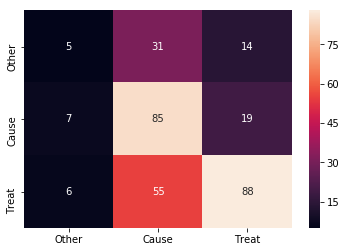

In [142]:
from sklearn.metrics import confusion_matrix
import seaborn

val_prediction = np.argmax(model.predict(preprocess(val['sentence'])), axis=1)
conf_matrix = confusion_matrix(gold_val, val_prediction)
#conf_matrix = [[0, 32, 8], [5, 121, 25], [4, 98, 41]] # Crowd
#conf_matrix = [[0, 40, 0], [0, 196, 0], [0, 196, 0]] # Regex
conf_matrix = [[  1, 13,  21],
 [  8,  75,  35],
 [ 10,  31, 116]] # regex old
conf_matrix = [[  4,  13,  19],
 [ 12,  75,  34],
 [ 11,  33, 109]] # + biotext old
conf_matrix = [[ 0, 24, 17],
 [ 7, 93, 16],
 [ 9, 68, 76]] # + both old
conf_matrix = [[ 5, 31, 14],
 [ 7, 85, 19],
 [ 6, 55, 88]] # +ade old
#conf_matrix = [[ 0, 7, 33], [ 0, 7, 133], [ 0, 9, 134]] # + BioText
#conf_matrix = [[ 0, 32, 8], [ 0, 110, 30], [ 0, 94, 49]] # + ADE
#conf_matrix = [[ 0, 21, 19], [ 0, 74, 66], [ 0, 64, 79]] # + both
classes = ['Other', 'Cause', 'Treat']
conf = pd.DataFrame(conf_matrix, index = classes,
                  columns = classes)
seaborn.heatmap(conf, annot=True)

In [35]:
accr = model.evaluate(preprocess(test['sentence']), Y_test)
print('Validation set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

125/125 [==============================] - 0s 2ms/step
Validation set
  Loss: 0.725
  Accuracy: 0.611


## Results

### Accuracy:

1) Only Crowd Labels: 0.680

2) Only Baseline: 0.611

3) Regex (11 LFs): 0.622

4) Basline + Regex: 0.634

5) Crowd + Regex:  0.676

6) 20% Crowd + Regex: 0.672

7) 40% Crowd + Regex: 0.606

8) 60% Crowd + Regex: 0.641

9) 80% Crowd + Regex: 0.57

10) Regex + BioText: 0.677

11) Regex + BioText + ADE: 0.632

### Confusion Matrix:
1) Only Crowd Labels: 
[[0  32  8]
 [5  121 25]
 [4  98  41]]
 
2) Only Baseline: 
[[17 23 0]
 [26 121 0]
 [54 89 0]]
 
3) Regex (11 LFs):
[[0  40  0]
 [0  196  0]
 [0  196  0]]
 
4) Baseline + Regex:
[[ 17  23  0]
 [ 30 121  0]
 [ 49 94  0]]
 
5) Crowd + Regex:
[[ 9  8  23]
 [ 15  47  78]
 [ 19  22  100]]

6) 20% Crowd + Regex:
[[7  9  24]
 [24  35 81]
 [21 18 100]]
 
7) 40% Crowd + Regex: 0.621

[[ 0, 39, 1], [ 0, 129, 11], [ 0, 140, 3]]

8) 60% Crowd + Regex: 0.633 [[ 1, 35, 4], [ 0, 106, 34], [ 0, 105, 38]]

9) 80% Crowd + Regex: 0.658 [[ 1, 23, 16], [ 2, 98, 40], [ 5, 94, 44]]

10) Regex + BioText: 0.628 [[ 0, 7, 33], [ 0, 7, 133], [ 0, 9, 134]]

11) Regex + ADE: 0.665 [[ 0, 32, 8], [ 0, 110, 30], [ 0, 94, 49]]

12) Regex + BioText + ADE: [[ 0, 21, 19], [ 0, 74, 66], [ 0, 64, 79]]

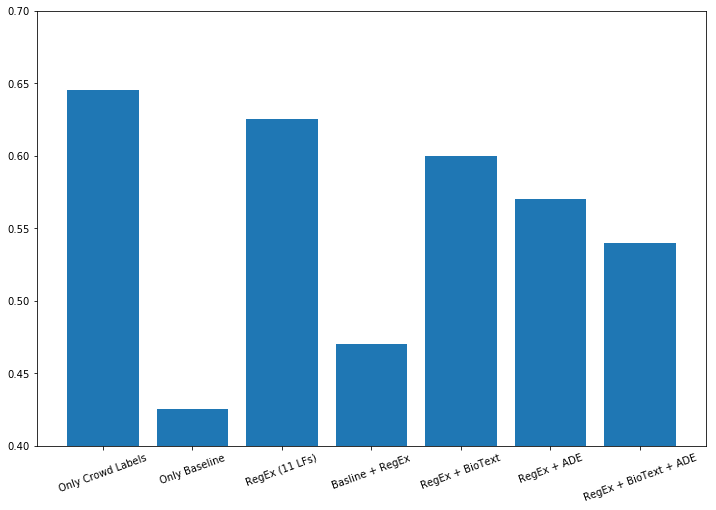

In [146]:
results = {'Only Crowd Labels': 0.645, 'Only Baseline': 0.425, 'RegEx (11 LFs)': 0.625, 'Basline + RegEx': 0.47,
            'RegEx + BioText': 0.6, 'RegEx + ADE': 0.57, 'RegEx + BioText + ADE': 0.54}

# '20% Crowd + Regex': 0.62, '40% Crowd + Regex': 0.621, '60% Crowd + Regex': 0.633,
#          '80% Crowd + Regex': 0.658, 
#'Crowd + Regex + ADE': 0.639, 'Crowd + Regex + BioText/ADE': 0.631
figure(figsize=(12, 8))

plt.bar(range(len(results)), list(results.values()), align='center')
plt.xticks(range(len(results)), list(results.keys()), rotation=20)

plt.ylim(0.4, 0.7)

plt.show()

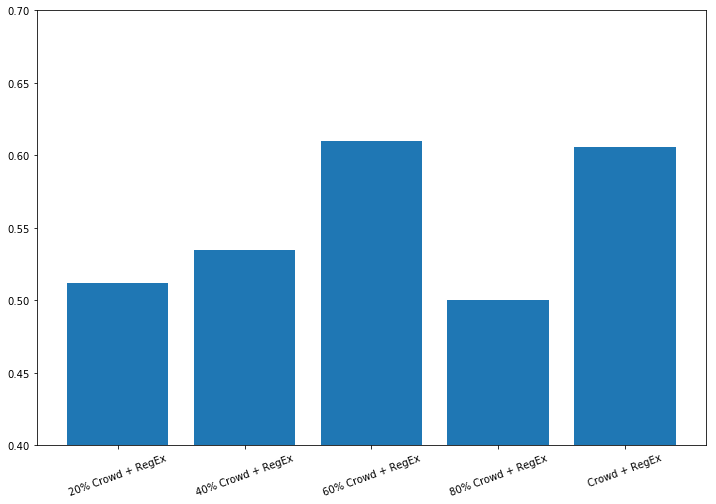

In [148]:
results = {'20% Crowd + RegEx': 0.512, '40% Crowd + RegEx': 0.535, '60% Crowd + RegEx': 0.610,
         '80% Crowd + RegEx': 0.50, 'Crowd + RegEx': 0.606}


#'Crowd + Regex + ADE': 0.639, 'Crowd + Regex + BioText/ADE': 0.631
figure(figsize=(12, 8))

plt.bar(range(len(results)), list(results.values()), align='center')
plt.xticks(range(len(results)), list(results.keys()), rotation=20)

plt.ylim(0.4, 0.7)

plt.show()